### Web Scraper & NLP uygulaması

Bu projede,
- DunyaHalleri.com sitesinden en az 100 tane haberin verisini çekiyoruz.
- İndirdiğimiz veriyi, değişkenlerinde Link, Başlık, Haber Metni, Haber Zamanı olan bir dataframe haline getiriyoruz.
- Daha sonrasında ise bir excel dosyası olarak kaydediyoruz.
- Ardından veriyi inceliyor ve görselleştiriyoruz.
- Veri ile Word2Vec modellemesi yapıyoruz.
- Son olarak da restgele seçilen 5 kelimeye en yakın 5 kelimeyi w2vec ile bulup dataframe haline getirerek ekrana yazdırıyoruz.

Kod boyunca kullanacağımız tüm kütüphaneleri ekleyerek başlayalım.


In [51]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
from gensim.models import Word2Vec

#### 1. DunyaHalleri.com'dan Verinin Çekilmesi
   - Siteden veri çekmek için BeautifulSoup kullanalım.
   - Çektiğimiz veriyi bir dataframe'de tutup en son daha sonra kullanmak adına pandas ile .xlsx uzantılı olarak kaydedelim.
   - Siteden çekeceğimiz veriler dataframe'imizde şu değişkenler altında toplanacak : Link, Başlık, Haber Metni, Haber Zamanı
   - URL adreslerinden hızlı bir şekilde veri çekebilmek adına haberCek isminde url parametresi alan bir fonksiyon tanımlayalım.

    

In [ ]:
columns = {'Link': [],'Başlık': [],'Haber Metni': [],'Haber Zamanı': []}
df = pd.DataFrame(columns) #Dataframe'i oluşturalım

def haberCek(url):
    
    r = requests.get(url) #url'imize bağlanalım
    #print(r.status_code) #200 döndük başarılı
    
    soup = BeautifulSoup(r.content,"lxml") #ilgili url'in içeriğini parçaladık, uygun formata getirdik
    
    baslik = soup.find("h1", attrs={"class":"entry-title h1"}).text
       
    haber_metinleri = soup.find_all("p")
    
    haber_metni="" 
    for metin in haber_metinleri:
        haber_metni+=metin.text  #Haber metni bir kaç <p> tagi içinde dağınık olduğu için hepsini birleştirdik
   
    tarih= soup.find("span", attrs={"class":"updated"}).text
    
    return([url,baslik,haber_metni,tarih])

print("Veri Çekme İşlemi Başladı!")
###Zaman Tasarrufu adına range(250) olacak şekilde çalıştırılmayabilir ancak bu da ilerleyen zamanlarda tahmin başarısının
###düşük/eksik olmasına sebep olacaktır.
for i in range(1,250): 
    haber= haberCek("https://www.dunyahalleri.com/haftanin-ozeti-"+ str(i))
    df= df.append(pd.Series(haber, index=df.columns ), ignore_index=True)
    #250 adet haftanın özetini çekiyor ve df'te tutuyoruz
    
#Daha sonra çektiğimiz verileri ileride tekrar çekmek zorunda olmadan kullanabilmek adına .xlsx uzantılı kaydediyoruz.   
writer = pd.ExcelWriter(r'haberler.xlsx',  index=False ,engine='xlsxwriter',options={'strings_to_urls': False})
df.to_excel(writer)
writer.close()

print("Veri Çekme İşlemi Tamamlandı!")

#### 2.Verinin Görselleştirmesi

- Kaydettiğimiz verimizi okuyalım ve veriyi temizleme işlemi yapalım.
- Ayrıca dataframe'imizdeki her satırda bulunan haber metninin kaç harften ve kaç karakterden oluştuğunu da df'e ekleyelim.

In [52]:
df= pd.read_excel("haberler.xlsx")

def preprocess(ReviewText):
    ReviewText = ReviewText.str.replace("(<br/>)", "")
    ReviewText = ReviewText.str.replace('(<a).*(>).*(</a>)', '')
    ReviewText = ReviewText.str.replace('(&amp)', '')
    ReviewText = ReviewText.str.replace('(&gt)', '')
    ReviewText = ReviewText.str.replace('(&lt)', '')
    ReviewText = ReviewText.str.replace('(\xa0)', ' ')  
    return ReviewText
df['Haber Metni'] = preprocess(df['Haber Metni'])
#Df'imize haber metninin kaç harften ve kaç karakterden oluştuğunu da ekleyelim.
df['Haber_Metni_Uzunluğu'] = df['Haber Metni'].astype(str).apply(len)
df['Haber_Metni_Kelime_Sayısı'] = df['Haber Metni'].apply(lambda x: len(str(x).split()))


Haber Metni Kelime Sayısı Dağılımı grafiği çizdirelim.

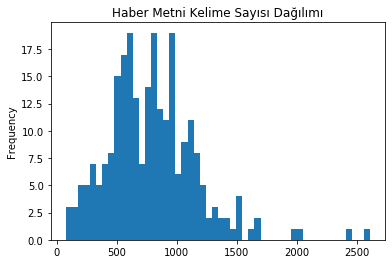

In [40]:
df['Haber_Metni_Kelime_Sayısı'].plot(
    kind='hist',
    bins=50,
    title='Haber Metni Kelime Sayısı Dağılımı')

Haber Metni Kelime Sayısı Dağılımı grafiği çizdirelim.

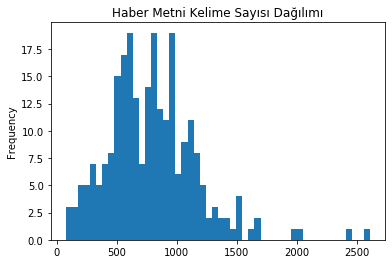

In [15]:
df['Haber_Metni_Kelime_Sayısı'].plot(
    kind='hist',
    bins=50,
    title='Haber Metni Kelime Sayısı Dağılımı')

Şimdi de haber metinleri içerisinde geçen en popüler 20 kelimemize bakalım.

bir 4644
ve 3895
bu 2378
da 2063
de 1932
için 1672
daha 972
çok 970
en 957
olarak 934
ile 802
var 693
dünya 672
gibi 653
kadar 596
yüzde 570
göre 566
her 556
yeni 546
olan 497


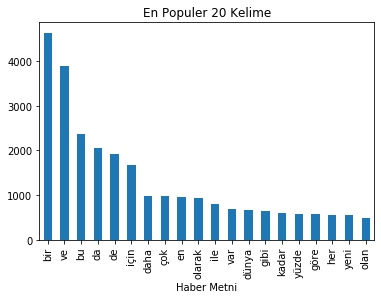

In [16]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(df['Haber Metni'],20)
for word, freq in common_words:
    print(word, freq)
df1 = pd.DataFrame(common_words, columns = ['Haber Metni' , 'count'])
df1.groupby('Haber Metni').sum()['count'].sort_values(ascending=False).plot(
    kind='bar',  title='En Populer 20 Kelime')

Gördüğünüz gibi çıkan sonuçlar pek de anlamlı kelimelerden oluşmuyor. Türkçede yer alan, tek başına -pek çoğunun- anlamı olmayan sadece anlamlı kelimeler/cümleler arasında kullanılınca anlam kazanan **etkisiz kelimeleri (stop words)** metnimizden çıkararak yukarıdaki kodu tekrar çalıştıralım.

dünya 672
yüzde 570
yeni 546
hafta 470
abd 460
halleri 443
türkiye 436
takip 404
yıl 378
kişi 377
değil 364
hayatını 351
büyük 341
eposta 330
fazla 328
inlinetweet 320
ilk 318
teşekkür 305
son 305
2019 290


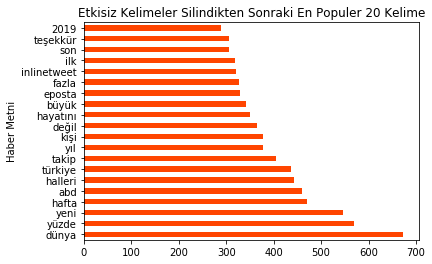

In [41]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words = open('turkce-stop-words', 'r', encoding ="UTF-8" ).read().split()).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]


common_words = get_top_n_words(df['Haber Metni'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Haber Metni' , 'count'])
df2.groupby('Haber Metni').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', color='orangered', title='Etkisiz Kelimeler Silindikten Sonraki En Populer 20 Kelime')

Gördüğünüz gibi şimdi çıkan sonuçlar çok daha anlamlı.

Şimdi de etkisiz kelimeleri çıkarttığımızda karşımıza çıkan en populer kelime ikililerine (bigram) bakalım.

dünya halleri 412
2019 tarihinde 253
halleri sitesi 251
yayın hayatını 250
sitesi ağustos 249
ağustos 2019 249
tarihinde yayın 249
hayatını noktalamıştır 249
teşekkür ederiz 187
haberleri eposta 164
eposta bültenimizle 164
bültenimizle takip 164
takip edin 164
edin teşekkür 164
ederiz terslik 164
terslik eposta 164
eposta adresiniz 164
adresiniz kişi 164
kişi kurumla 164
kurumla paylaşılmayacak 164


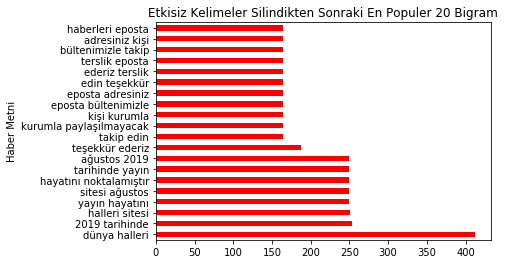

In [42]:

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2) , stop_words = open('turkce-stop-words', 'r', encoding ="UTF-8" ).read().split()).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Haber Metni'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Haber Metni' , 'count'])
df2.groupby('Haber Metni').sum()['count'].sort_values(ascending=False).plot(
    kind='barh',color='red',title="Etkisiz Kelimeler Silindikten Sonraki En Populer 20 Bigram")


Bir de en çok peşpeşe kullanılan kelime üçlülerine (trigram) bakalım.

halleri sitesi ağustos 249
sitesi ağustos 2019 249
ağustos 2019 tarihinde 249
2019 tarihinde yayın 249
tarihinde yayın hayatını 249
yayın hayatını noktalamıştır 249
dünya halleri sitesi 229
bir terslik var 165
haberleri eposta bültenimizle 164
eposta bültenimizle takip 164
bültenimizle takip edin 164
takip edin teşekkür 164
edin teşekkür ederiz 164
teşekkür ederiz bir 164
ederiz bir terslik 164
terslik var eposta 164
var eposta adresiniz 164
eposta adresiniz hiçbir 164
adresiniz hiçbir kişi 164
hiçbir kişi ve 164


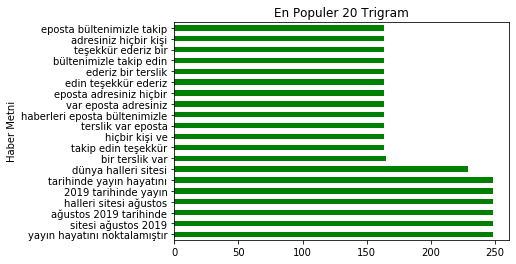

In [43]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(3, 3)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(df['Haber Metni'], 20)
for word, freq in common_words:
    print(word, freq)
df2 = pd.DataFrame(common_words, columns = ['Haber Metni' , 'count'])
df2.groupby('Haber Metni').sum()['count'].sort_values(ascending=False).plot(
    kind='barh',color='green',title="En Populer 20 Trigram")

Şimdi ise daha görsel bir şeyler yapalım. Bir kelime bulutu oluşturalım ve bakalım *Haber Metinleri*nde hangi kelimeler daha popüler

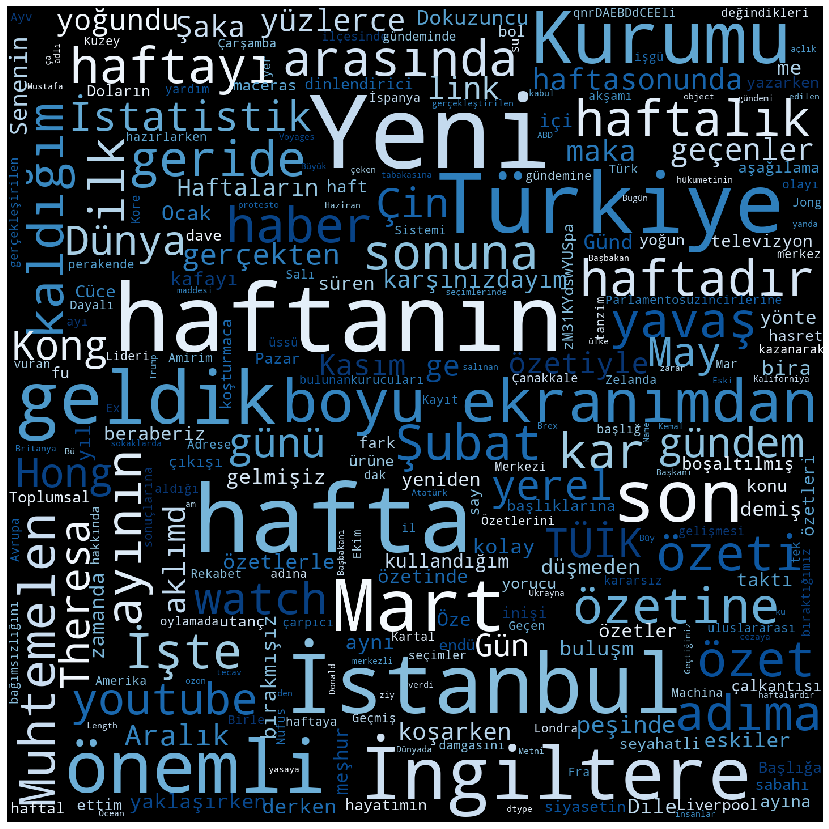

In [54]:
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        stopwords=open('turkce-stop-words', 'r', encoding ="UTF-8" ).read().split(),
        max_words=400,
        max_font_size=60,
        width=480, 
        height=480, 
        background_color="black",
        colormap="Blues",
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(15, 15))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df['Haber Metni'])

#### 3.Veri ile Word2Vec Modellemesinin Yapılması
- Bu kısımda gensim kütüphanesini kullanarak basit bir word2vec modellemesi yapacağız.
- Haber MEtinlerimiz paragraf haline df'te tutulduğu için, bu büyük paragrafları öncelikle kelime kelime ayıralım ve dfsplit değişkeninde saklayalım
- Daha sonra modelimizi oluşturup, kaydedelim. Böylelikle her seferinde tekrar tekrar modelimizi oluşturmak zahmetinden kurtulmuş olacağız.

In [47]:
dfsplit=[]
for i in range(60):
    dfsplit.append(df["Haber Metni"][i].split())
    
model = Word2Vec(dfsplit, 
        size=150,
        window=10,
        min_count=2,
        workers=10,
        iter=10)

model.save("word2vec.model")

model = Word2Vec.load("word2vec.model")

E:\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


Oluşturduğumuz modeli test etmek adına şöyle bir örnek yapabiliriz. Gireceğimiz "Dünya" kelimesi ile benzerliği en yüksek olan 15 kelimeyi ve benzerlik oranını getiren bir kod yazalım.

**NOT: Toplam verimizi zaman ve performans kısıtlarından ötürü 60 satır olacak şekilde aldık. Bu sebeple modelimiz sadece öğrendiği ilk 60 satırdaki verilere göre tahmin yapmaktadır. Yukarıda da koddaki gibi 60 değil de 250 satır veri ile kod tekrar çalıştırıldığında daha verimli sonuçlar elde edilecektir.**

In [48]:
model_test=model.wv.most_similar(positive=['dünya'],topn=15)
print(model_test)

[('benzer', 0.9999163746833801), ('etmeye', 0.9999144673347473), ('yani', 0.999905526638031), ('yok', 0.9998491406440735), ('siteleri', 0.9998323321342468), ('iletişim', 0.9997822046279907), ('olsun.', 0.9997596740722656), ('çalışıyorum.', 0.9997515678405762), ('eden', 0.9997407793998718), ('medya', 0.9997401833534241), ('bilgileri', 0.9997242093086243), ('işin', 0.9997192621231079), ('adam', 0.9997174143791199), ('/', 0.999715268611908), ('sık', 0.9997144937515259)]


Seçtiğimiz Dünya, Teknoloji, Yapay, Blockchain, Robotik kelimelerine en yakın 5 kelimeyi bulup, bu bulduğumuz verileri bir df içinde tutalım.

In [49]:
df_konuBasliklari = pd.DataFrame(columns=["Konu Başlıkları", "W2VEC Sonuçları"])

def w2vec_sonuclari(keyword):
    veri_temp = []
    for i in range(4):
        try:
            veri_temp.append(model.wv.most_similar(positive=[keyword],topn=4)[i][0])
            
            
        except:
            continue
    return veri_temp


konu_basliklari=["dünya", "teknoloji", "yapay", "blockchain", "robotik"]

for konu_basligi,i in zip(konu_basliklari,range(5)):
    df_konuBasliklari.at[i, 'Konu Başlıkları'] = konu_basligi
    df_konuBasliklari.at[i, "W2VEC Sonuçları"] = w2vec_sonuclari(konu_basligi)

print(df_konuBasliklari)

  Konu Başlıkları                    W2VEC Sonuçları
0           dünya        [benzer, etmeye, yani, yok]
1       teknoloji         [video, kaç, bana, içerik]
2           yapay  [etmek, ABD’de, yapılan, siteler]
3      blockchain                                 []
4         robotik   [gereken, İngilizce, imza, şeye]


### Teşekkürler :)

**Not:** Bu kod Ka|Ve Ar-Ge Eğitim mülakatı için yazılmıştır.